# Cryptocurrency Portfolio Backtesting with Factor Investing and Potfolio Insurance Strategy


## Table of Contents

1. [Introduction](#Introduction)
2. [Setup and Imports](#Setup)
3. [Data Loading](#Data_Loading)
4. [Factor Calculation](#Factor_Calculation)
5. [Strategy Backtest](#Strategy_Backtest)
6. [Performance Metrics](#Performance_Metrics)
7. [Visualizations](#Visualizations)
8. [Conclusion](#Conclusion)

---

<a id='Introduction'></a>
## Introduction

This notebook performs a backtest of a cryptocurrency portfolio using a **Factor Investing with Stop Protection (SP)** strategy. The SP strategy dynamically adjusts the portfolio's hedge ratio based on the performance of long and short positions to mitigate potential losses, enhancing the traditional factor investing approach.

**Key Steps:**

1. **Setup and Imports**: Import necessary libraries.
2. **Data Loading**: Load historical price and market cap data for selected cryptocurrencies.
3. **Factor Calculation**: Compute Momentum, Size, and Value factors.
4. **Strategy Backtest**: Implement and backtest the Factor Investing with SP strategy.
5. **Performance Metrics**: Calculate Sharpe Ratio, Beta, and Alpha.
6. **Visualizations**: Plot portfolio performance, equity drawdowns, daily returns on assets, and portfolio holdings breakdown.
7. **Conclusion**: Summarize findings and potential next steps.

---

<a id='Setup'></a>
## Setup and Imports

First, we import all the required libraries for data manipulation, analysis, and visualization.


In [2]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.api import OLS
import statsmodels.api as sm
import yfinance as yf

%matplotlib inline

<a id='Data_Loading'></a>
## Data Loading

We load historical price and market capitalization data for the top 10 cryptocurrencies (excluding USDT and USDC) from CSV files located in the Data folder. The data spans from October 1, 2021, to September 29, 2024.

In [3]:
# Parameters
start_date = "2021-10-01"
end_date = "2024-09-29"  # Ensure yfinance has data up to this date
initial_investment = 100_000_000  # 100M USD

# Load data for top 10 cryptocurrencies (excluding USDT and USDC)
top_10_coins = ['BTC', 'ETH', 'BNB', 'XRP', 'ADA', 'DOGE', 'SOL', 'TON', 'TRX', 'AVAX']
folder_path = 'Data'  # Path to CSV files containing market cap data

def load_price_and_market_cap_data(folder_path, coins, start_date, end_date):
    """
    Load price and market cap data from CSV files.
    """
    price_data = {}
    market_cap_data = {}

    for coin in coins:
        file_path = os.path.join(folder_path, f"{coin}.csv")
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue
        df = pd.read_csv(file_path, parse_dates=['Start'], index_col='Start')

        # Store close prices for price data
        price_data[coin] = df['Close']

        # Store market cap data
        market_cap_data[coin] = df[['Market Cap', 'Volume']]

    # Convert dictionaries to DataFrames
    price_data = pd.DataFrame(price_data)

    # Handle missing values in price data (forward fill or drop)
    price_data.ffill(inplace=True)  # Forward fill missing values
    price_data.dropna(inplace=True)  # Drop rows with persistent NaN values

    # Convert market_cap_data to proper DataFrames
    market_cap_data = {coin: df for coin, df in market_cap_data.items()}

    return price_data, market_cap_data

# Load price and market cap data from CSV files
price_data, market_cap_data = load_price_and_market_cap_data(folder_path, top_10_coins, start_date, end_date)

# Display the first few rows of price data
print("Price Data Head:")
display(price_data.head())

Price Data Head:


,BTC,ETH,BNB,XRP,ADA,DOGE,SOL,TON,TRX,AVAX
Start,,,,,,,,,,
2021-08-27,49005.9495,3268.2547,493.4016,1.174040,2.938407,0.293226,87.9080,0.781087,0.088081,50.0430
2021-08-28,48864.0249,3247.4221,486.2568,1.149294,2.855787,0.285629,97.2368,0.731698,0.088390,50.2641
2021-08-29,48876.7643,3236.1842,481.5356,1.144495,2.864885,0.282029,94.3016,0.553893,0.088654,47.5776
2021-08-30,47020.6765,3233.0987,462.3070,1.105831,2.739861,0.272074,109.8693,0.691245,0.086451,41.3548
2021-08-31,47225.2696,3441.6881,466.1393,1.191076,2.783445,0.278981,108.8281,0.744206,0.088930,39.6894


## Price Data Preview
Below is the preview of the loaded price data:

In [4]:
price_data.head()

,BTC,ETH,BNB,XRP,ADA,DOGE,SOL,TON,TRX,AVAX
Start,,,,,,,,,,
2021-08-27,49005.9495,3268.2547,493.4016,1.174040,2.938407,0.293226,87.9080,0.781087,0.088081,50.0430
2021-08-28,48864.0249,3247.4221,486.2568,1.149294,2.855787,0.285629,97.2368,0.731698,0.088390,50.2641
2021-08-29,48876.7643,3236.1842,481.5356,1.144495,2.864885,0.282029,94.3016,0.553893,0.088654,47.5776
2021-08-30,47020.6765,3233.0987,462.3070,1.105831,2.739861,0.272074,109.8693,0.691245,0.086451,41.3548
2021-08-31,47225.2696,3441.6881,466.1393,1.191076,2.783445,0.278981,108.8281,0.744206,0.088930,39.6894


<a id='Factor_Calculation'></a>
<a id='Factor_Calculation'></a>
## Factor Calculation

We calculate three key factors for our strategy:

- **Momentum**: Measures the past week's return.
- **Size**: Represents the market capitalization of the cryptocurrencies.
- **Value**: Inverse of the NVT (Network Value to Transactions) ratio.

In [5]:
def calculate_factors(price_data, cap_data, rolling_window=7):
    """
    Calculate Momentum, Size, and Value factors.
    """
    # Momentum: past week return
    momentum = price_data.pct_change(rolling_window).shift(1)

    # Size: market cap of the coins
    size = pd.DataFrame({coin: cap_data[coin]['Market Cap'] for coin in cap_data})

    # Value: inverse of NVT ratio (Market Cap / Volume)
    value = pd.DataFrame({coin: cap_data[coin]['Market Cap'] / cap_data[coin]['Volume'] for coin in cap_data})

    # Handle potential divide-by-zero or inf values in NVT ratio
    value.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf values with NaN
    value.fillna(0, inplace=True)  # Replace NaN values with 0

    value = 1 / value
    value = value.clip(lower=-1e9, upper=1e9)  # Clip values to a reasonable range

    return momentum, size, value

# Calculate factors
momentum, size, value = calculate_factors(price_data, market_cap_data)

# Display the first few rows of each factor
print("Momentum Factor Head:")
display(momentum.head())

print("Size Factor Head:")
display(size.head())

print("Value Factor Head:")
display(value.head())


Momentum Factor Head:


,BTC,ETH,BNB,XRP,ADA,DOGE,SOL,TON,TRX,AVAX
Start,,,,,,,,,,
2021-08-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Size Factor Head:


,BTC,ETH,BNB,XRP,ADA,DOGE,SOL,TON,TRX,AVAX
Start,,,,,,,,,,
2018-01-01,2.292229e+11,7.311417e+10,0.0,8.706376e+10,1.814591e+10,9.701365e+08,NaN,NaN,3.049863e+09,NaN
2018-01-02,2.345984e+11,8.436733e+10,0.0,9.037632e+10,1.940001e+10,1.026499e+09,NaN,NaN,4.302503e+09,NaN
2018-01-03,2.538832e+11,8.749899e+10,0.0,1.085968e+11,2.529529e+10,1.014908e+09,NaN,NaN,5.207058e+09,NaN
2018-01-04,2.510367e+11,9.300369e+10,0.0,1.373512e+11,3.150835e+10,1.054012e+09,NaN,NaN,1.067987e+10,NaN
2018-01-05,2.718434e+11,9.791364e+10,0.0,1.283867e+11,2.876060e+10,1.196150e+09,NaN,NaN,1.496927e+10,NaN


Value Factor Head:


,BTC,ETH,BNB,XRP,ADA,DOGE,SOL,TON,TRX,AVAX
Start,,,,,,,,,,
2018-01-01,0.041566,0.026632,1.000000e+09,0.027601,0.008949,0.052708,1.000000e+09,1.000000e+09,0.123722,1.000000e+09
2018-01-02,0.049102,0.044136,1.000000e+09,0.025898,0.010312,0.057322,1.000000e+09,1.000000e+09,0.177925,1.000000e+09
2018-01-03,0.060997,0.046204,1.000000e+09,0.038683,0.020168,0.066923,1.000000e+09,1.000000e+09,0.235940,1.000000e+09
2018-01-04,0.071120,0.052601,1.000000e+09,0.055653,0.021758,0.064735,1.000000e+09,1.000000e+09,0.230019,1.000000e+09
2018-01-05,0.072137,0.055721,1.000000e+09,0.051043,0.016094,0.096690,1.000000e+09,1.000000e+09,0.237644,1.000000e+09


## Factors Preview

In [6]:
momentum.head()
size.head()
value.head()

,BTC,ETH,BNB,XRP,ADA,DOGE,SOL,TON,TRX,AVAX
Start,,,,,,,,,,
2018-01-01,0.041566,0.026632,1.000000e+09,0.027601,0.008949,0.052708,1.000000e+09,1.000000e+09,0.123722,1.000000e+09
2018-01-02,0.049102,0.044136,1.000000e+09,0.025898,0.010312,0.057322,1.000000e+09,1.000000e+09,0.177925,1.000000e+09
2018-01-03,0.060997,0.046204,1.000000e+09,0.038683,0.020168,0.066923,1.000000e+09,1.000000e+09,0.235940,1.000000e+09
2018-01-04,0.071120,0.052601,1.000000e+09,0.055653,0.021758,0.064735,1.000000e+09,1.000000e+09,0.230019,1.000000e+09
2018-01-05,0.072137,0.055721,1.000000e+09,0.051043,0.016094,0.096690,1.000000e+09,1.000000e+09,0.237644,1.000000e+09


<a id='Strategy_Backtest'></a>
<a id='Strategy_Backtest'></a>
## Strategy Backtest

We implement the Factor Investing with Stop Protection (SP) strategy, which adjusts the portfolio's hedge ratio based on the relative performance of long and short positions to manage risk effectively.

### Strategy Functions
#### Adjust Hedge Ratio

In [7]:
def adjust_hedge(long_return_total, short_return_average):
    """
    Adjust hedge ratio based on long and short returns.
    """
    if long_return_total < short_return_average:
        return 0.35  # Adjust this value as needed
    else:
        return 0.0

#### Protection Strategy SP

In [8]:
def protection_strategy_sp(weekly_return, long_return_total, short_return_average):
    """
    Stop Protection (SP) strategy to adjust weekly returns based on hedge ratio.
    """
    hedge_ratio = adjust_hedge(long_return_total, short_return_average)
    adjusted_weekly_return = long_return_total * (1 - hedge_ratio) - short_return_average
    return adjusted_weekly_return

#### Rebalancing Function

In [9]:
def rebalancing(portfolio, target_allocation):
    """
    Rebalance the portfolio to match the target allocation.
    """
    total_value = sum(portfolio.values())
    for asset, allocation in target_allocation.items():
        portfolio[asset] = total_value * allocation
    return portfolio

#### Backtest Function

In [10]:
def backtest_strategy(start_date, end_date, initial_investment, price_data, cap_data, 
                     protection_strategy, 
                     floor_ratio=0.9, 
                     multiplier=3, 
                     threshold=0.05, 
                     base_allocation_tipp=0.5, 
                     max_allocation_vbpi=1.0, 
                     min_allocation_vbpi=0.0):
    """
    Backtest the crypto strategy with dynamic long/short and protection strategy.
    """
    # Initialize portfolio metrics
    portfolio_value = initial_investment
    portfolio_history = []
    returns_history = []
    holdings_history = []  # To track portfolio holdings over time

    dates = pd.date_range(start=start_date, end=end_date, freq='W-SUN')

    # Calculate floor based on initial investment
    floor = initial_investment * floor_ratio

    # Calculate factors
    momentum, size, value = calculate_factors(price_data, cap_data)

    # Standardize factors (handle NaN and inf values)
    scaler = StandardScaler()

    # Apply StandardScaler while handling NaN values
    momentum_std = pd.DataFrame(scaler.fit_transform(momentum.fillna(0)), index=momentum.index, columns=momentum.columns)
    size_std = pd.DataFrame(scaler.fit_transform(size.fillna(0)), index=size.index, columns=size.columns)
    value_std = pd.DataFrame(scaler.fit_transform(value.fillna(0)), index=value.index, columns=value.columns)

    # Combine factors (equal weight)
    combined_signal = (momentum_std + size_std + value_std) / 3

    # Restrict signals to the backtest period (starting from start_date)
    combined_signal = combined_signal.loc[start_date:end_date]

    for date in dates:
        portfolio_date = date
        holdings = {}  # To store holdings for this date

        if portfolio_date in combined_signal.index:
            signals = combined_signal.loc[portfolio_date]

            # Check if there are any valid signals
            if signals.isna().all():
                # Append current portfolio value and zero return
                portfolio_history.append(portfolio_value)
                returns_history.append(0.0)
                holdings_history.append(holdings)
                continue

            # Split signals based on their strength
            long_threshold = 0.5  # Go long if signal > 0.5
            short_threshold = -0.5  # Go short if signal < -0.5

            # Dynamic long/short allocation based on signal strength
            long_coins = signals[signals > long_threshold].index
            short_coins = signals[signals < short_threshold].index

            # Ensure there are coins to long or short
            if len(long_coins) == 0 and len(short_coins) == 0:
                portfolio_history.append(portfolio_value)
                returns_history.append(0.0)
                holdings_history.append(holdings)
                continue

            # Compute value-weighted allocation
            total_market_cap = size.loc[portfolio_date, long_coins].sum() if len(long_coins) > 0 else 1
            weights = size.loc[portfolio_date, long_coins] / total_market_cap if len(long_coins) > 0 else pd.Series(0, index=long_coins)

            try:
                # Find the next trading day after portfolio_date
                future_dates = price_data.index[price_data.index > portfolio_date]
                if future_dates.empty:
                    portfolio_history.append(portfolio_value)
                    returns_history.append(0.0)
                    holdings_history.append(holdings)
                    continue
                next_date = future_dates[0]

                # Calculate long returns
                long_price_current = price_data.loc[portfolio_date, long_coins]
                long_price_next = price_data.loc[next_date, long_coins]
                long_returns = (long_price_next / long_price_current - 1) * weights
                long_return_total = long_returns.sum()

                # Calculate short returns
                short_return_total = 0.0
                if len(short_coins) > 0:
                    short_price_current = price_data.loc[portfolio_date, short_coins]
                    short_price_next = price_data.loc[next_date, short_coins]
                    short_returns = (short_price_next / short_price_current - 1)
                    short_return_total = short_returns.mean() if not short_returns.empty else 0.0

            except Exception as e:
                portfolio_history.append(portfolio_value)
                returns_history.append(0.0)
                holdings_history.append(holdings)
                continue

            # Calculate original weekly return
            original_weekly_return = long_return_total - short_return_total

            # Apply protection strategy
            adjusted_weekly_return = protection_strategy(original_weekly_return, long_return_total, short_return_total)

            # Update portfolio value
            portfolio_value *= (1 + adjusted_weekly_return)

            # Record portfolio holdings (for visualization)
            if len(long_coins) > 0:
                for coin in long_coins:
                    holdings[coin] = weights[coin] * (1 - adjust_hedge(long_return_total, short_return_total))
            if len(short_coins) > 0:
                for coin in short_coins:
                    holdings[coin] = - (1 / len(short_coins)) if len(short_coins) > 0 else 0

            # Record portfolio history
            portfolio_history.append(portfolio_value)
            returns_history.append(adjusted_weekly_return)
            holdings_history.append(holdings)
        else:
            portfolio_history.append(portfolio_value)
            returns_history.append(0.0)
            holdings_history.append(holdings)

    # Convert history to DataFrame
    if portfolio_history:
        portfolio_history_df = pd.DataFrame(portfolio_history, index=dates, columns=['Portfolio Value'])
    else:
        portfolio_history_df = pd.DataFrame(columns=['Portfolio Value'], index=dates)

    # Convert holdings history to DataFrame
    holdings_history_df = pd.DataFrame(holdings_history, index=dates).fillna(0)

    return portfolio_history_df, returns_history, holdings_history_df

#### Running the Backtest

In [11]:
# Select Protection Strategy
protection_strategy = protection_strategy_sp  # Factor Investing with Stop Protection

# Define SP Parameters
floor_ratio = 0.9  # 90% floor
multiplier = 3  # CPPI multiplier (not used in SP)
threshold = 0.05  # Volatility threshold (not used in SP)
base_allocation_tipp = 0.5  # Base allocation for TIPP (not used in SP)
max_allocation_vbpi = 1.0  # Max allocation for VBPI (not used in SP)
min_allocation_vbpi = 0.0  # Min allocation for VBPI (not used in SP)

# Backtest the strategy
portfolio_history, returns_history, holdings_history = backtest_strategy(
    start_date, 
    end_date, 
    initial_investment, 
    price_data, 
    market_cap_data, 
    protection_strategy,
    floor_ratio=floor_ratio,
    multiplier=multiplier,
    threshold=threshold,
    base_allocation_tipp=base_allocation_tipp,
    max_allocation_vbpi=max_allocation_vbpi,
    min_allocation_vbpi=min_allocation_vbpi
)

#### Portfolio History Preview

In [12]:
print("Portfolio History Head:")
display(portfolio_history.head())

Portfolio History Head:


,Portfolio Value
2021-10-03,1.009030e+08
2021-10-10,1.048921e+08
2021-10-17,1.047308e+08
2021-10-24,1.074698e+08
2021-10-31,1.086288e+08


#### Portfolio Holdings Preview

In [13]:
print("Holdings History Head:")
display(holdings_history.head())

Holdings History Head:


,BTC,ETH,BNB,XRP,ADA,DOGE,SOL,TRX,TON,AVAX
2021-10-03,0.572413,0.254973,0.045756,0.030825,0.045183,0.018375,0.032474,0.000000,0.0,0.0
2021-10-10,0.641082,0.257954,0.000000,0.033526,0.043545,0.019738,0.000000,0.004156,0.0,0.0
2021-10-17,0.426700,0.168772,0.029177,0.000000,0.025351,0.000000,0.000000,0.000000,0.0,0.0
2021-10-24,0.000000,0.668378,0.110718,0.000000,0.093220,0.046700,0.080985,0.000000,0.0,0.0
2021-10-31,0.000000,0.745236,0.128182,0.074822,0.000000,0.051761,0.000000,0.000000,0.0,0.0


<a id='Performance_Metrics'></a>
<a id='Performance_Metrics'></a>
## Performance Metrics

We evaluate the backtested portfolio using the following metrics:

- **Sharpe Ratio**: Measures the risk-adjusted return.
- **Beta**: Indicates the portfolio's volatility relative to Bitcoin (BTC).
- **Alpha**: Represents the portfolio's performance relative to the expected return based on its Beta.

### Performance Metrics Function

In [14]:
def calculate_metrics(portfolio_history, returns_history, start_date, end_date):
    """
    Calculate Sharpe Ratio, Beta, and Alpha for the backtested portfolio.
    """
    # Convert returns_history to a pandas Series with backtest dates as index
    backtest_dates = pd.date_range(start=start_date, end=end_date, freq='W-SUN')
    returns_series = pd.Series(returns_history, index=backtest_dates)

    # Calculate Sharpe Ratio
    returns_cleaned = returns_series.dropna()

    if len(returns_cleaned) == 0:
        return np.nan, np.nan, np.nan

    sharpe_ratio = np.mean(returns_cleaned) / np.std(returns_cleaned) * np.sqrt(52)  # Annualized Sharpe Ratio

    # Fetch BTC data using yfinance
    btc_ticker = 'BTC-USD'

    try:
        btc_data = yf.download(btc_ticker, start=start_date, end=end_date, progress=False)
    except Exception as e:
        print(f"Error fetching BTC data: {e}")
        return sharpe_ratio, np.nan, np.nan

    if btc_data.empty:
        print("Fetched BTC data is empty. Please check the ticker and date range.")
        return sharpe_ratio, np.nan, np.nan

    # Ensure the data is sorted in ascending order
    btc_data.sort_index(inplace=True)

    # Calculate daily returns
    market_returns_daily = btc_data['Close'].pct_change().dropna()

    # Resample daily market returns to weekly returns (W-SUN) by compounding
    market_returns_weekly = market_returns_daily.resample('W-SUN').agg(lambda x: (1 + x).prod() - 1)

    # Align the indices of returns_history and market_returns_weekly using common dates
    common_dates = returns_series.index.intersection(market_returns_weekly.index)
    aligned_returns_history = returns_series.loc[common_dates]
    aligned_market_returns = market_returns_weekly.loc[common_dates]

    # Ensure both series have no NaN values
    aligned_returns_history = aligned_returns_history.dropna()
    aligned_market_returns = aligned_market_returns.dropna()

    # Re-align indices to ensure they match exactly
    common_dates_final = aligned_returns_history.index.intersection(aligned_market_returns.index)
    aligned_returns_history = aligned_returns_history.loc[common_dates_final]
    aligned_market_returns = market_returns_weekly.loc[common_dates_final]

    # Check if we have enough data to run the regression
    if len(aligned_returns_history) < 2:
        print("Not enough data for regression.")
        return sharpe_ratio, np.nan, np.nan

    # Convert data to float to avoid dtype issues
    aligned_returns_history = aligned_returns_history.astype(float)
    aligned_market_returns = aligned_market_returns.astype(float)

    # Calculate Beta and Alpha using OLS regression
    X = sm.add_constant(aligned_market_returns)  # Adds a constant term to the predictor
    model = OLS(aligned_returns_history, X).fit()
    beta = model.params[aligned_market_returns.name]
    alpha = model.params['const']

    return sharpe_ratio, beta, alpha

#### Calculating Metrics

In [15]:
# Calculate performance metrics
sharpe_ratio, beta, alpha = calculate_metrics(portfolio_history, returns_history, start_date, end_date)
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Beta: {beta:.4f}")
print(f"Alpha: {alpha:.4f}")

Sharpe Ratio: 1.3576
Beta: -0.0075
Alpha: 0.0059


<a id='Visualizations'></a>
<a id='Visualizations'></a>
## Visualizations

To better understand the portfolio performance, we include various plots:

1. **Portfolio Value Over Time**
2. **Equity Drawdown Over Time**
3. **Daily Returns on Assets**
4. **Portfolio Holdings Breakdown Over Time**

### 1. Portfolio Value Over Time

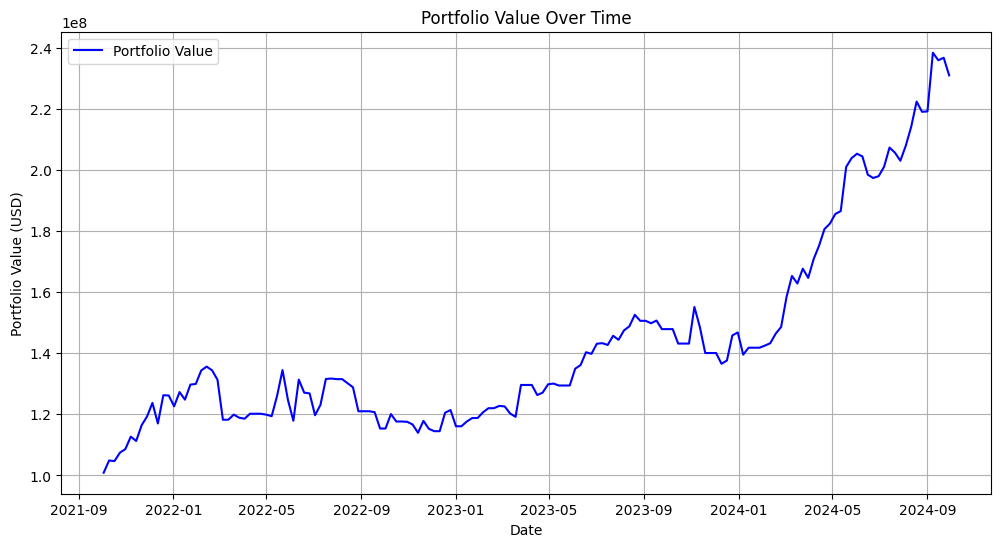

In [16]:
def plot_portfolio(portfolio_history):
    """
    Plot the portfolio value over time.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_history.index, portfolio_history['Portfolio Value'], label='Portfolio Value', color='blue')
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_portfolio(portfolio_history)

### 2. Equity Drawdown

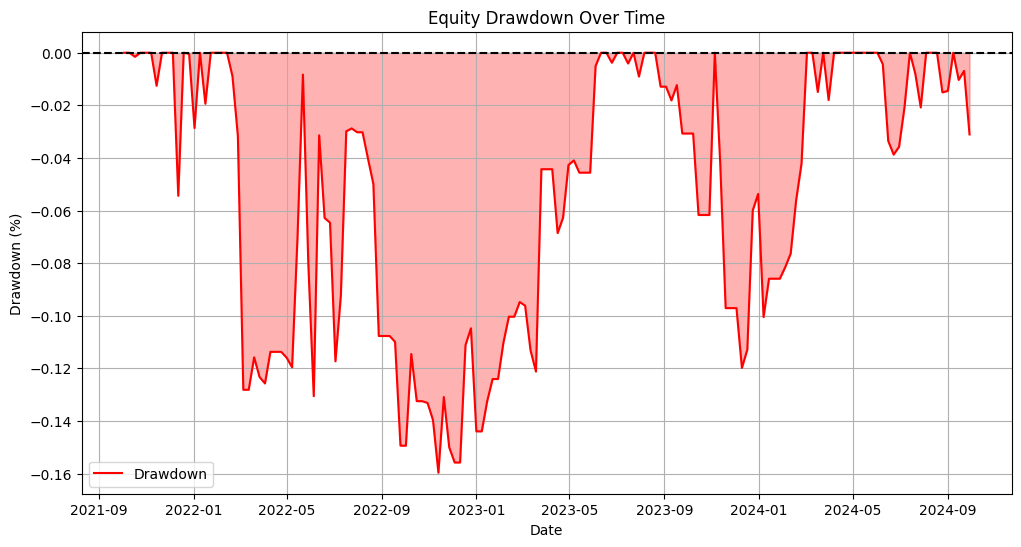

In [17]:
def plot_equity_drawdown(portfolio_history):
    """
    Plot the equity drawdown over time.
    """
    portfolio_history['Max Value'] = portfolio_history['Portfolio Value'].cummax()
    portfolio_history['Drawdown'] = (portfolio_history['Portfolio Value'] - portfolio_history['Max Value']) / portfolio_history['Max Value']

    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_history.index, portfolio_history['Drawdown'], label='Drawdown', color='red')
    plt.fill_between(portfolio_history.index, portfolio_history['Drawdown'], color='red', alpha=0.3)
    plt.title('Equity Drawdown Over Time')
    plt.xlabel('Date')
    plt.ylabel('Drawdown (%)')
    plt.axhline(0, color='black', linestyle='--')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_equity_drawdown(portfolio_history)

### 3. Daily Returns on Assets

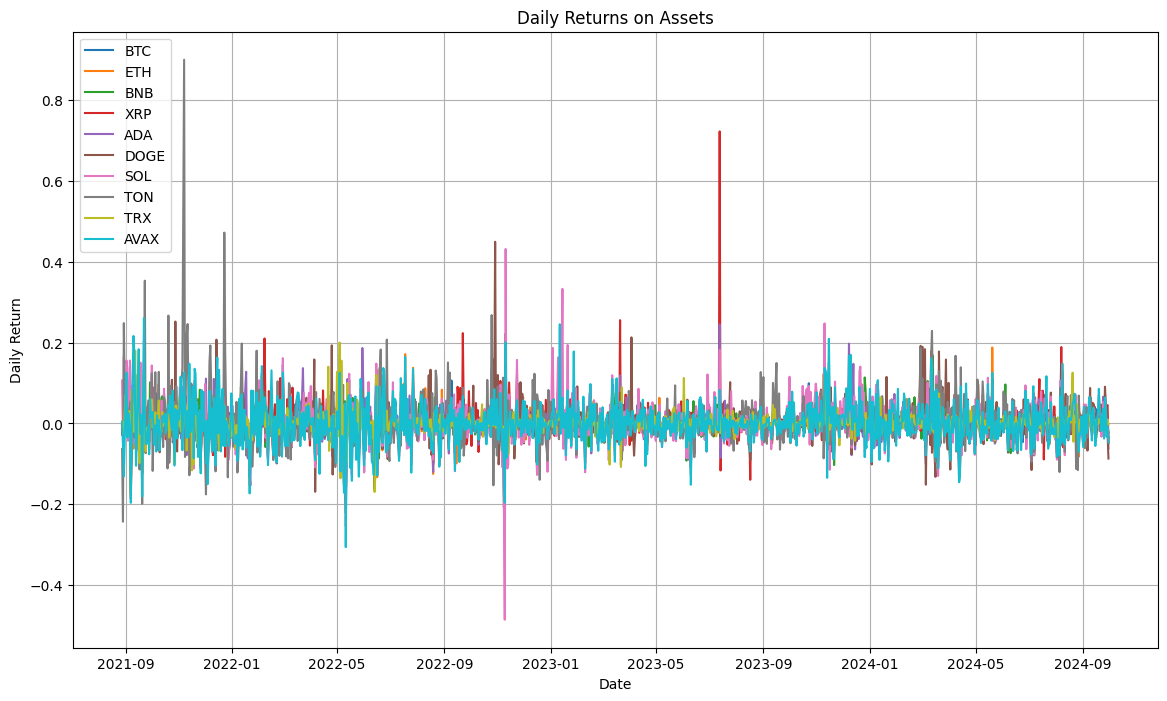

In [18]:
def plot_daily_returns_on_assets(price_data):
    """
    Plot the daily returns on assets over time.
    """
    daily_returns = price_data.pct_change().dropna()  # Calculate daily returns
    plt.figure(figsize=(14, 8))
    for column in daily_returns.columns:
        plt.plot(daily_returns.index, daily_returns[column], label=column)
    plt.title('Daily Returns on Assets')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

plot_daily_returns_on_assets(price_data)

### 4. Portfolio Holdings Breakdown Over Time
To visualize how the portfolio's holdings in each cryptocurrency change over time, we use a stacked area chart. This provides insights into the allocation dynamics driven by the Factor Investing with SP strategy.

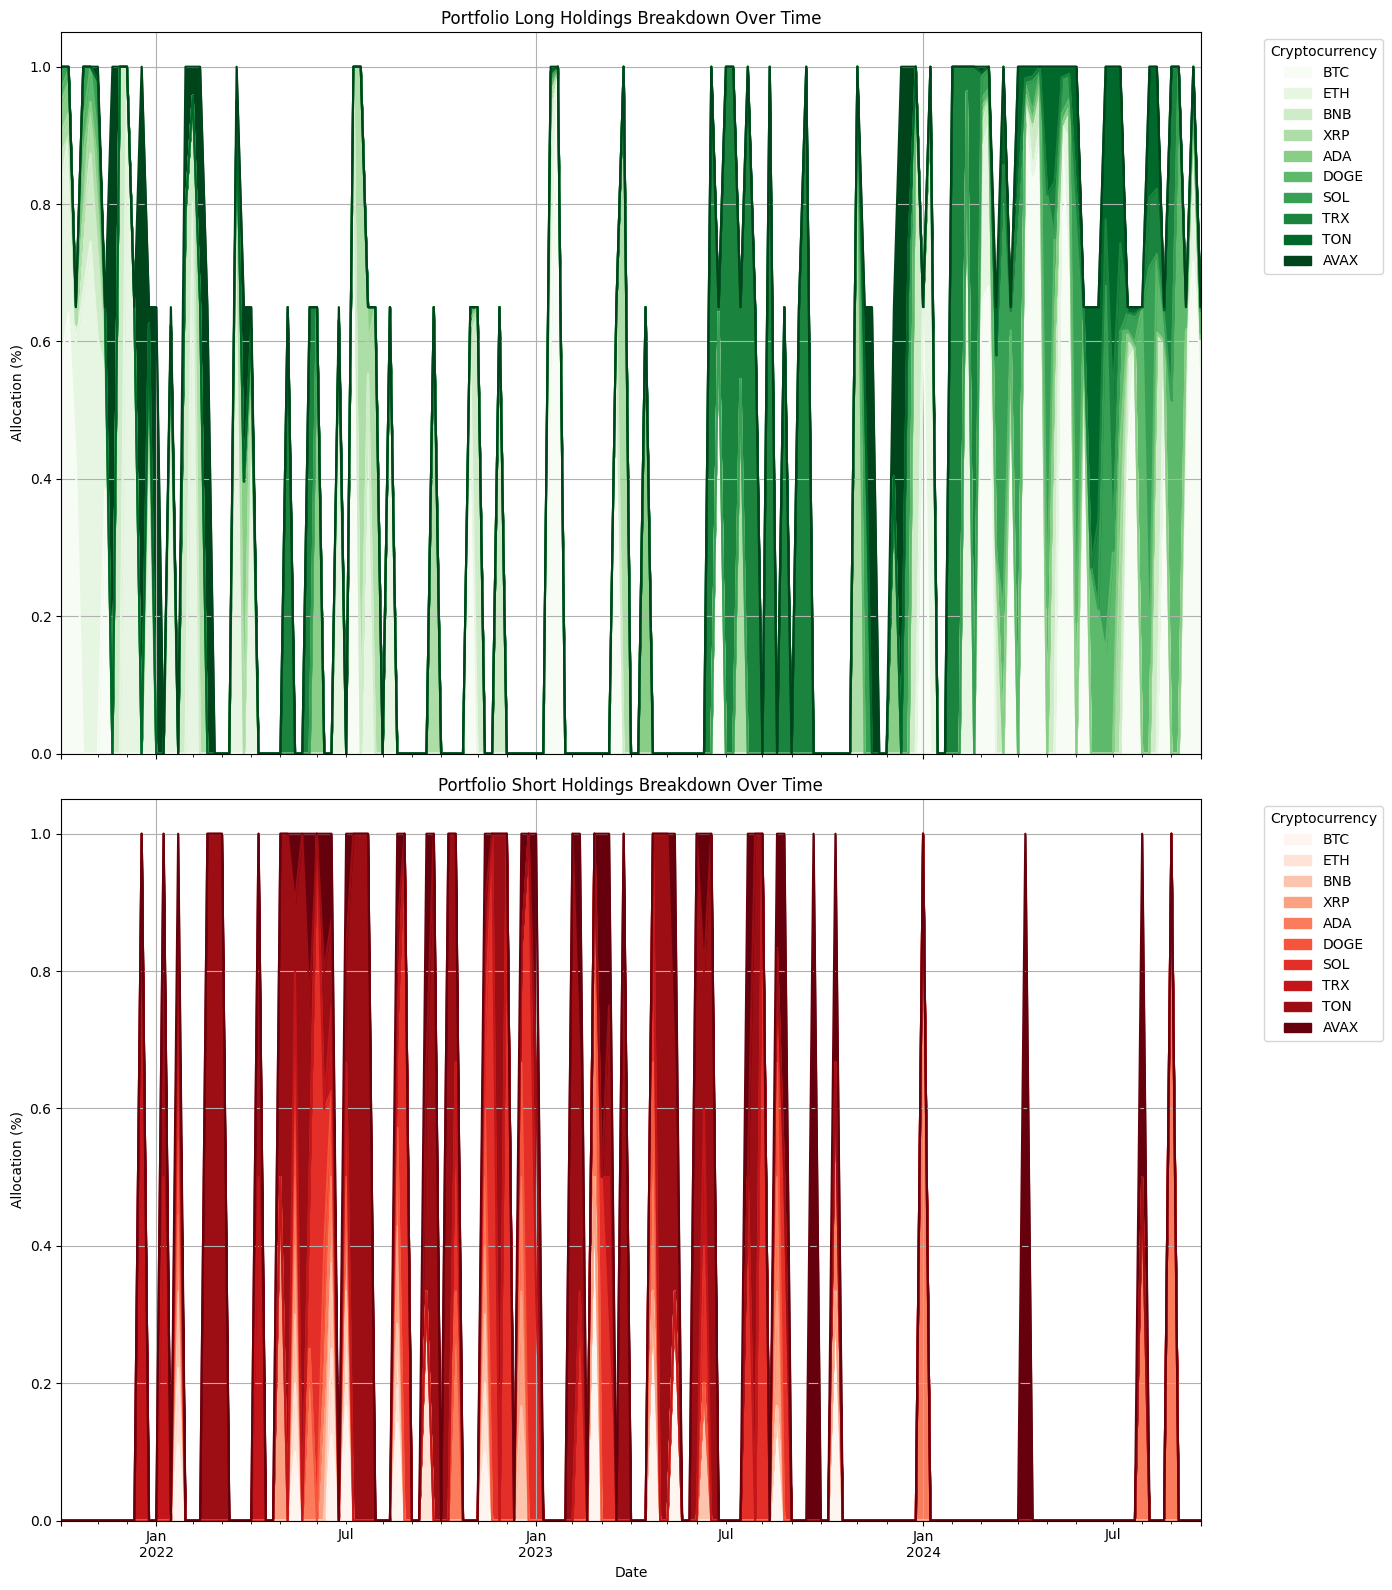

In [21]:
def plot_portfolio_holdings(holdings_history_df):
    """
    Plot the portfolio holdings breakdown over time, separating long and short positions.
    """
    # Separate long and short holdings
    longs = holdings_history_df.clip(lower=0)
    shorts = holdings_history_df.clip(upper=0).abs()

    # Create subplots for longs and shorts
    fig, axes = plt.subplots(2, 1, figsize=(14, 16), sharex=True)

    # Plot Long Holdings
    longs.plot.area(stacked=True, ax=axes[0], cmap='Greens')
    axes[0].set_title('Portfolio Long Holdings Breakdown Over Time')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Allocation (%)')
    axes[0].legend(title='Cryptocurrency', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0].grid(True)

    # Plot Short Holdings
    shorts.plot.area(stacked=True, ax=axes[1], cmap='Reds')
    axes[1].set_title('Portfolio Short Holdings Breakdown Over Time')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Allocation (%)')
    axes[1].legend(title='Cryptocurrency', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()
        
plot_portfolio_holdings(holdings_history)

<a id='Conclusion'></a>
## Conclusion

In this notebook, we implemented and backtested a Factor Investing with Stop Protection (SP) strategy for a cryptocurrency portfolio. The SP strategy dynamically adjusts the hedge ratio based on the performance of long and short positions to manage risk effectively, complementing traditional factor investing principles.

### Key Takeaways:
- **Dynamic Hedging**: The SP strategy adjusts the portfolio's exposure based on market conditions, potentially reducing losses during downturns.
- **Factor Integration**: Incorporating Momentum, Size, and Value factors enhances the selection and weighting of assets in the portfolio.
- **Performance Metrics**: Metrics like Sharpe Ratio, Beta, and Alpha provide insights into the risk-adjusted returns and the portfolio's behavior relative to the market.
- **Visual Insights**: Visualizations such as portfolio value plots, equity drawdowns, daily asset returns, and holdings breakdowns help in understanding the strategy's effectiveness over time.

### Next Steps:
- **Parameter Tuning**: Experiment with different hedge ratios, thresholds, and factor combinations to optimize performance.
- **Additional Factors**: Incorporate other factors such as volatility, liquidity, or sentiment for a more comprehensive strategy.
- **Risk Management**: Implement advanced risk management techniques like Value at Risk (VaR) or Conditional Value at Risk (CVaR) to further safeguard the portfolio.
- **Broader Asset Selection**: Extend the analysis to include more cryptocurrencies or other asset classes for diversification.
- **Real-Time Backtesting**: Integrate real-time data feeds to simulate live trading conditions.